<a href="https://colab.research.google.com/github/talkome/heart-failure-prediction-model/blob/main/heart_attack_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Heart Attack Prediction

# Sources

- https://medium.com/pytorch/using-optuna-to-optimize-pytorch-hyperparameters-990607385e36
- https://pytorch.org/
- https://www.pytorchlightning.ai/
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://optuna.org/

# Preparing

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.9 MB/s 
     |████████████████████████████████| 210 kB 54.2 MB/s 
     |████████████████████████████████| 81 kB 9.5 MB/s 
     |████████████████████████████████| 78 kB 7.2 MB/s 
     |████████████████████████████████| 112 kB 51.8 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 146 kB 50.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=b1bf6e73af2218291bb47ffee482fac0abbe2b364c49baddbf4149cb65b2f668
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import KNNImputer

from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim


import optuna
from optuna.trial import TrialState

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve, accuracy_score

seed=42 

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

## Custom functions definition

In [63]:
def get_scores(y, y_pred):
    data={'Accuracy': np.round(accuracy_score(y, y_pred),2),
    'Precision':np.round(precision_score(y, y_pred),2),
    'Recall':np.round(recall_score(y, y_pred),2),
    'F1':np.round(f1_score(y, y_pred),2),
    'ROC AUC':np.round(roc_auc_score(y, y_pred),2)}
    scores_df = pd.Series(data).to_frame('scores')
    return scores_df

In [62]:
def conf_matrix(y, y_pred):
    fig, ax =plt.subplots(figsize=(3.5,3.5))
    labels=['No','Yes']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title('Heart Failure?', fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test')
    ax.set_xlabel('Predicted')

## Dataset Loading

In [4]:
df = pd.read_csv('../input/heart-failure-prediction/heart.csv', skipinitialspace=True)

In [5]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


# Data Analysis

Are there null values?

In [7]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no null values.

Are there duplicate values?

In [8]:
df[df.duplicated()]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


There are no duplicate values.

To simplify the following analysis, we will define a function to plot numerical features by plotly.

In [10]:
num_cols = ['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak']

def num_plot(df, col):
    fig = px.histogram(df, x=col, color="HeartDisease",
                       marginal="box")
    fig.update_layout(height=400, width=500, showlegend=True)
    fig.update_traces(marker_line_width=1,marker_line_color="black")
    fig.show()

In [11]:
for col in num_cols:
    num_plot(df,col)

There are outliers values for Colesterol and restingBP=0

In [12]:
df[df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


We will drop this value!

In [13]:
df = df[(df['RestingBP'] > 0)]

What about 0 values of Cholesterol?

In [14]:
df[df['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


There are 171 patients with a cholesterol value = 0, which is not possible.

In [15]:
num_plot(df,'Cholesterol')

In [16]:
print('Mean',df.Cholesterol.mean())
print('Median',df.Cholesterol.median())
print('Mode',df.Cholesterol.mode()[0])

Mean 199.0163576881134
Median 223.0
Mode 0


The most frequent value (mode) is cholesterol = 0.

In [17]:
df_no_chol = df[df['Cholesterol']==0]

In [18]:
for col in num_cols:
    num_plot(df_no_chol,col)

It looks like there are no common features among these patients with missing cholesterol value.<br>
We will impute the missing values of Cholesterol after splitting the dataset into training and test sets. For now, we label these values as 'NaN'.

In [19]:
df['Cholesterol'] = df['Cholesterol'].replace({0:np.nan})

# Categorical Features Encoding

Depending on the number of different possible values for each categorical variable, we will choose if encoding the variable by label encoding or one hot encoding (OHE).

## Gender

Sex has only two classes, so we can encode it by 0 and 1.

In [20]:
df.Sex = df.Sex.replace({'M':0,'F':1})

## ChestPainType

In [21]:
df.ChestPainType.value_counts()

ASY    496
NAP    202
ATA    173
TA      46
Name: ChestPainType, dtype: int64

There are only 3 classes, we can encode it by OHE

## ExerciseAngina

In [22]:
df.ExerciseAngina.value_counts()

N    546
Y    371
Name: ExerciseAngina, dtype: int64

There are two classes, we will encode it by 0 and 1.

In [23]:
df.ExerciseAngina = df.ExerciseAngina.replace({'N':0,'Y':1})

## ST_Slope

In [24]:
df.ST_Slope.value_counts()

Flat    459
Up      395
Down     63
Name: ST_Slope, dtype: int64

There are only 3 classes, we can encode it by OHE

## RestingECG

In [25]:
df.RestingECG.value_counts()

Normal    551
LVH       188
ST        178
Name: RestingECG, dtype: int64

There are only 3 classes, we can encode it by OHE

We will encode the variables by OHE using the convenient get_dummies function from pandas library.

In [26]:
encoded_df = pd.get_dummies(df, drop_first=True)

# Data preprocessing for Machine Learning modeling

In [27]:
fig = px.histogram(df, x="HeartDisease", color="HeartDisease")
fig.update_layout(height=400, width=500, showlegend=True)
fig.update_traces(marker_line_width=1,marker_line_color="black")
fig.show()

Good news, the target variable looks balanced.

In [28]:
X = encoded_df.drop('HeartDisease', axis = 1)

In [29]:
y = encoded_df['HeartDisease']

## Train - Test split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=seed, stratify=y)

## Missing Cholesterol values imputation

After extracting the training set, we can study how to impute missing values of the cholesterol column. We perform the imputation only on the training set to avoid any data leakage: the best value for imputation obtained on the training set will be used also on the test set.

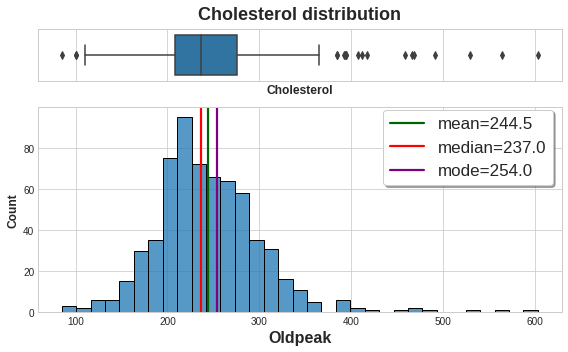

In [31]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,5),gridspec_kw={"height_ratios": (.2, .8)})
ax[0].set_title('Cholesterol distribution',fontsize=18)
sns.boxplot(x='Cholesterol', data=X_train, ax=ax[0])
ax[0].set(yticks=[])
sns.histplot(x='Cholesterol', data=X_train, ax=ax[1])
ax[1].set_xlabel(col, fontsize=16)
plt.axvline(X_train['Cholesterol'].mean(), color='darkgreen', linewidth=2.2, label='mean=' + str(np.round(X_train['Cholesterol'].mean(),1)))
plt.axvline(X_train['Cholesterol'].median(), color='red', linewidth=2.2, label='median='+ str(np.round(X_train['Cholesterol'].median(),1)))
plt.axvline(X_train['Cholesterol'].mode()[0], color='purple', linewidth=2.2, label='mode='+ str(X_train['Cholesterol'].mode()[0]))
plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=17, fancybox=True, shadow=True, frameon=True)
plt.tight_layout()
plt.show()

By visual inspection, a good value for imputing missing cholesterol values could be 240.

In [32]:
chol = 240 

In [33]:
X_train['Cholesterol'] = X_train['Cholesterol'].fillna(chol)

In [34]:
X_test['Cholesterol'] = X_test['Cholesterol'].fillna(chol)

In [35]:
scaler = StandardScaler()   
X_train = scaler.fit_transform(X_train)          
X_test = scaler.transform(X_test)  

# Dimensionality reduction by PCA

We have 15 features/columns in the dataset, is it possible to remove some of them and still keep a high explainability?

In [36]:
pca = PCA()
pca.fit_transform(X_train);

In [37]:
cum_sum = np.cumsum(pca.explained_variance_ratio_)*100
comp= [n for n in range(len(cum_sum))]

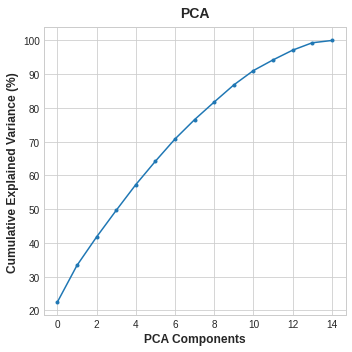

In [38]:
plt.figure(figsize=(5,5))
plt.plot(comp, cum_sum, marker='.')
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA')
plt.show()

It looks like the PCA curve does not have any clear elbow. We should not drop any of the features.

## Train - Validation split

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed)

## Create Custom Dataset class

In [40]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [41]:
class CustomDataset:
    def __init__(self, X_data, y_data, device=DEVICE):
        self.X_data = X_data
        self.y_data = y_data 
    
    def __len__ (self):
        return len(self.X_data)
    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

In [42]:
train_data = CustomDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train.values))

In [43]:
val_data = CustomDataset(torch.FloatTensor(X_valid), torch.FloatTensor(y_valid.values))

In [44]:
test_data = CustomDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test.values))

## Parameters definition

In [45]:
BATCHSIZE = 16

## Dataloader definition

In [46]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCHSIZE)
valid_loader = DataLoader(dataset=val_data, batch_size=1)
test_loader = DataLoader(dataset=test_data, batch_size=1)

# Hyperoptimization by Optuna

# Neural Network hypermodel

In the following we will define a **n-layers Neural Network hypermodel**, where n is the number of hidden layers chosen by OPTUNA. The idea of a hypermodel is that some hyperparameters are defined in a range of values, where the optmization algorithm (OPTUNA) will search to find the 'best' ones by optimizing a certain metric, for example the validation accuracy of the model. <br>
In this work, the hyperparameters that will be optimized are:
- number of layers
- number of neurons for each layer
- learning rate of Adam optimizer

In [47]:
def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 2)
    layers = []

    in_features = 15
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_{}".format(i), 8, 25)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_uniform("dropout_{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))
        in_features=out_features
    layers.append(nn.Linear(out_features, 1))

    return nn.Sequential(*layers)

Then, we need to define an objective function, including the train and evaluation of our model.

# OPTUNA

In [48]:
EPOCHS = 40

In [49]:
def objective(trial):

    # call the define_model method
    model = define_model(trial).to(DEVICE)

    # Optimizer and loss definition
    lr = trial.suggest_float("lr", 5e-4, 1e-2, log=True)
    optimizer =  getattr(optim, 'Adam')(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss() 
    # Using the logit binary CE, we include the sigmoid function in the prediction output during the loss calculation
    
    train_acc = []
    train_loss = []
    
    valid_acc = []
    valid_loss = []
    
    total_step = len(train_loader)
    total_step_val = len(valid_loader)

    for epoch in range(EPOCHS):
        
        running_loss=0
        correct=0
        total=0
        
        #TRAINING

        model.train()

        for batch_idx, (X_train_batch, y_train_batch) in enumerate(train_loader):
            X_train_batch, y_train_batch = X_train_batch.to(DEVICE), y_train_batch.to(DEVICE)
            optimizer.zero_grad()
            output = model(X_train_batch)
            y_pred = torch.round(torch.sigmoid(output))
            #LOSS
            loss = criterion(output, y_train_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss+=loss.item() #sum all batch losses
            #ACCURACY
            correct += torch.sum(y_pred==y_train_batch.unsqueeze(1)).item()
            total += y_train_batch.size(0)
        train_acc.append(100 * correct / total) 
        train_loss.append(running_loss/total_step) #get average loss among all batches dividing total loss by the number of batches

        # VALIDATION
        correct_v = 0
        total_v = 0
        batch_loss = 0
        with torch.no_grad():
            model.eval()
            for batch_idx, (X_valid_batch, y_valid_batch) in enumerate(valid_loader):
                X_valid_batch,y_valid_batch=X_valid_batch.to(DEVICE),y_valid_batch.to(DEVICE)
                #PREDICTION
                output = model(X_valid_batch)
                y_pred = torch.round(torch.sigmoid(output))
                #LOSS
                loss_v = criterion(output, y_valid_batch.unsqueeze(1))
                batch_loss+=loss_v.item()
                #ACCURACY
                correct_v += torch.sum(y_pred==y_valid_batch.unsqueeze(1)).item()
                total_v += y_valid_batch.size(0)
            valid_acc.append(100 * correct_v / total_v)
            valid_loss.append(batch_loss/total_step_val)

        trial.report(np.mean(valid_loss), epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
    return np.mean(valid_loss)

Finally, we can start the optimization with Optuna.

In [50]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")

params = []

for key, value in trial.params.items():
    params.append(value)
    print("    {}: {}".format(key, value))

[I 2022-05-27 07:00:52,371] A new study created in memory with name: no-name-99483cf9-581f-40e0-ab50-1db7c56e8ce9
[I 2022-05-27 07:00:55,815] Trial 0 finished with value: 0.3051341281603993 and parameters: {'n_layers': 2, 'n_units_0': 15, 'dropout_0': 0.24628497518467812, 'n_units_1': 10, 'dropout_1': 0.2807246931448302, 'lr': 0.0017558722570816736}. Best is trial 0 with value: 0.3051341281603993.
[I 2022-05-27 07:00:59,347] Trial 1 finished with value: 0.294133953852187 and parameters: {'n_layers': 2, 'n_units_0': 15, 'dropout_0': 0.3666172012853144, 'n_units_1': 24, 'dropout_1': 0.24106905195832548, 'lr': 0.003744854678619809}. Best is trial 1 with value: 0.294133953852187.
[I 2022-05-27 07:01:02,696] Trial 2 finished with value: 0.293730216278129 and parameters: {'n_layers': 2, 'n_units_0': 20, 'dropout_0': 0.4954081181923394, 'n_units_1': 24, 'dropout_1': 0.23853084869705382, 'lr': 0.0036895856963762496}. Best is trial 2 with value: 0.293730216278129.
[I 2022-05-27 07:01:06,133] Tr

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  74
  Number of complete trials:  26
Best trial:
  Value:  0.28307816983063927
  Params: 
    n_layers: 1
    n_units_0: 18
    dropout_0: 0.27210511281121463
    lr: 0.008764173278055065


In [51]:
params

[1, 18, 0.27210511281121463, 0.008764173278055065]

We can extract the best parameters from the list:

In [52]:
n_layers = params[0]

units_1 = params[1]
dropout_1 = np.round(params[2],5)

lr = np.round(params[3],8)

Then, we define a new Neural Network by Pytorch, where the hyperparameters will have the optimized values obtaiend with optuna.

# Pytorch Neural Network modeling

In [53]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer_1 = nn.Linear(X_train.shape[1], units_1)
        self.layer_out = nn.Linear(units_1, 1) 
        self.dropout1 = nn.Dropout(p=dropout_1)
        
    def forward(self, inputs):
        x = F.relu(self.layer_1(inputs))
        x = self.dropout1(x)
        x = self.layer_out(x)
        
        return x

In [54]:
model = Net()
model.to(DEVICE)
print(model)

Net(
  (layer_1): Linear(in_features=15, out_features=18, bias=True)
  (layer_out): Linear(in_features=18, out_features=1, bias=True)
  (dropout1): Dropout(p=0.27211, inplace=False)
)


In [55]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)

We set the number of epochs:

In [56]:
EPOCHS = 100

# Pytorch Neural Network training

Finally we can start the training of the Neural Network with the optimized hyperparameters

In [57]:
# Model Training

early_stopping_patience = 15
early_stopping_counter = 0

train_acc = []
train_loss = []

valid_acc = []
valid_loss = []

total_step = len(train_loader)
total_step_val = len(valid_loader)

valid_loss_min=np.inf

for epoch in range(EPOCHS):
    
    running_loss=0
    correct=0
    total=0
    
    #TRAINING

    model.train()

    for batch_idx, (X_train_batch, y_train_batch) in enumerate(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(DEVICE), y_train_batch.to(DEVICE)
        optimizer.zero_grad()
        output = model(X_train_batch)
        y_pred = torch.round(torch.sigmoid(output))
        #LOSS
        loss = criterion(output, y_train_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss+=loss.item() #sum loss for every batch
        #ACCURACY
        correct += torch.sum(y_pred==y_train_batch.unsqueeze(1)).item()
        total += y_train_batch.size(0)
    train_acc.append(100 * correct / total) #calculate accuracy among all entries in the batches
    train_loss.append(running_loss/total_step)  #get average loss among all batches dividing total loss by the number of batches

    # VALIDATION
    correct_v = 0
    total_v = 0
    batch_loss = 0
    with torch.no_grad():
        model.eval()
        for batch_idx, (X_valid_batch, y_valid_batch) in enumerate(valid_loader):
            X_valid_batch,y_valid_batch=X_valid_batch.to(DEVICE),y_valid_batch.to(DEVICE)
            #PREDICTION
            output = model(X_valid_batch)
            y_pred = torch.round(torch.sigmoid(output))
            #LOSS
            loss_v = criterion(output, y_valid_batch.unsqueeze(1))
            batch_loss+=loss_v.item()
            #ACCURACY
            correct_v += torch.sum(y_pred==y_valid_batch.unsqueeze(1)).item()
            total_v += y_valid_batch.size(0)
        valid_acc.append(100 * correct_v / total_v) 
        valid_loss.append(batch_loss/total_step_val)
    
    
    if np.mean(valid_loss) <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {epoch + 0:01}: Validation loss decreased ({valid_loss_min:.6f} --> {np.mean(valid_loss):.6f}).  Saving model ...')
        valid_loss_min = np.mean(valid_loss)
        early_stopping_counter=0 #reset counter if validation loss decreases
    else:
        print(f'Epoch {epoch + 0:01}: Validation loss did not decrease')
        early_stopping_counter+=1

    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', epoch)
        break

    print(f'\t Train_Loss: {np.mean(train_loss):.4f} Train_Acc: {(100 * correct / total):.3f} Val_Loss: {np.mean(valid_loss):.4f}  BEST VAL Loss: {valid_loss_min:.4f}  Val_Acc: {(100 * correct_v / total_v):.3f}\n')

Epoch 0: Validation loss decreased (inf --> 0.304101).  Saving model ...
	 Train_Loss: 0.4823 Train_Acc: 78.812 Val_Loss: 0.3041  BEST VAL Loss: 0.3041  Val_Acc: 89.103

Epoch 1: Validation loss decreased (0.304101 --> 0.294043).  Saving model ...
	 Train_Loss: 0.4239 Train_Acc: 83.628 Val_Loss: 0.2940  BEST VAL Loss: 0.2940  Val_Acc: 89.103

Epoch 2: Validation loss decreased (0.294043 --> 0.291335).  Saving model ...
	 Train_Loss: 0.4008 Train_Acc: 85.554 Val_Loss: 0.2913  BEST VAL Loss: 0.2913  Val_Acc: 88.462

Epoch 3: Validation loss decreased (0.291335 --> 0.289094).  Saving model ...
	 Train_Loss: 0.3866 Train_Acc: 86.196 Val_Loss: 0.2891  BEST VAL Loss: 0.2891  Val_Acc: 89.744

Epoch 4: Validation loss decreased (0.289094 --> 0.288379).  Saving model ...
	 Train_Loss: 0.3767 Train_Acc: 84.912 Val_Loss: 0.2884  BEST VAL Loss: 0.2884  Val_Acc: 88.462

Epoch 5: Validation loss decreased (0.288379 --> 0.286776).  Saving model ...
	 Train_Loss: 0.3685 Train_Acc: 85.554 Val_Loss: 0.2

Now we can get the predictions by looping over the test loader.

In [58]:
y_pred_prob_list = []
y_pred_list = []


# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

with torch.no_grad():
        model.eval()
        for batch_idx, (X_test_batch, y_test_batch) in enumerate(test_loader):
            X_test_batch = X_test_batch.to(DEVICE)
            #PREDICTION
            output = model(X_test_batch)
            y_pred_prob = torch.sigmoid(output)
            y_pred_prob_list.append(y_pred_prob.cpu().numpy())
            y_pred = torch.round(y_pred_prob)
            y_pred_list.append(y_pred.cpu().numpy())

In [59]:
y_pred_prob_list = [a.squeeze().tolist() for a in y_pred_prob_list]
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

# PyTorch Results Summary

## Classification Report

In [60]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        62
           1       0.86      0.91      0.88        76

    accuracy                           0.87       138
   macro avg       0.87      0.87      0.87       138
weighted avg       0.87      0.87      0.87       138



## Confusion Matrix

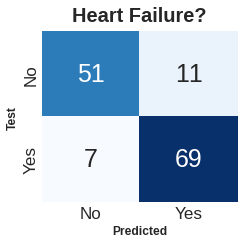

In [64]:
conf_matrix(y_test, y_pred_list)

## PyTorch NN ROC curve

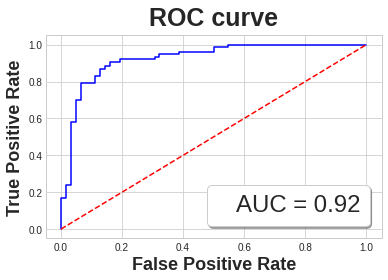

In [65]:
plt.figure(figsize = (5.5, 4))

fpr, tpr, _ = roc_curve(y_test, y_pred_prob_list)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve',fontsize=25)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.legend(loc = 'lower right', fontsize=24, fancybox=True, shadow=True, frameon=True, handlelength=0)
plt.show()

**The results of the hyperoptimized Pytorch Neural Network are satisfying, since all the scores are around 90%.**<br>
**In particular, the best Recall score I could get is 92%, which in medical applications is the best score to look at, since having false negatives is a crime**